# Demonstrating new `ts_wep` `Instrument` class

Author: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2022-11-01**
<br>Software Versions:
  - `ts_wep`: **v3.0.0**
  - `lsst_distrib`: **w_2022_37**
  
## Motivation

The new `instrument` class in `ts_wep` is designed to make it easier to specify telescope configuration settings as one interacts with data during Commissioning. Previously telescope configuration parameters were hard-coded in parameter files that only allowed certain values for some settings. Now the telescope configuration can either be stored in a configuration file that can be run as part of an automated pipeline (see [section on pipeline files below](#pipelineFiles)) or if running interactively in a notebook the settings can be configured when setting up the tasks that are part of the AOS pipeline.
  
## Goal

Demonstrate how to use the new instrument class on both corner wavefront sensors and science sensors using test data that is a part of the `ts_wep` package.

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Data

We will use data from the test repo included in `ts_wep`.

In [3]:
ts_wep_dir = os.getenv('TS_WEP_DIR')

In [4]:
# Repository with the raw data
butler_repo = os.path.join(ts_wep_dir, 'tests', 'testData', 'gen3TestRepo')

In [5]:
butler = Butler(butler_repo)
registry = butler.registry

Specify dataIds available.

In [6]:
dataIdExtraCwfs = {
    'instrument': 'LSSTCam', 
    'detector': 191, 
    'exposure': 4021123106000,
    'visit': 4021123106000
}
dataIdIntraCwfs = {
    'instrument': 'LSSTCam', 
    'detector': 192, 
    'exposure': 4021123106000,
    'visit': 4021123106000
}

In [7]:
dataIdExtraScience = {
    "instrument": "LSSTCam",
    "detector": 94,
    "exposure": 4021123106001,
    "visit": 4021123106001,
}
dataIdIntraScience = {
    "instrument": "LSSTCam",
    "detector": 94,
    "exposure": 4021123106002,
    "visit": 4021123106002,
}

Load raw data for both CWFS and Science Sensors for examples.

In [8]:
rawExtraCwfs = butler.get('raw', dataId=dataIdExtraCwfs, collections=['LSSTCam/raw/all'])
rawIntraCwfs = butler.get('raw', dataId=dataIdIntraCwfs, collections=['LSSTCam/raw/all'])
rawExtraScience = butler.get('raw', dataId=dataIdExtraScience, collections=['LSSTCam/raw/all'])
rawIntraScience = butler.get('raw', dataId=dataIdIntraScience, collections=['LSSTCam/raw/all'])

## Run ISR

Since the `ts_wep` test repo only contains the raw data, we need to run ISR to get `postISR` images that we can pass through into our gen3 pipeline tasks that use the new instrument configurations.

In [9]:
isrConfig = IsrTaskConfig()

In [10]:
isrConfig.doApplyGains = True
isrConfig.doOverscan = True
isrConfig.doBias = False
isrConfig.doVariance = False
isrConfig.doLinearize = False
isrConfig.doDefect = False
isrConfig.doNanMasking = False
isrConfig.doInterpolate = False
isrConfig.doBrighterFatter = False
isrConfig.doDark = False
isrConfig.doFlat = False
isrConfig.doFringe = False

In [11]:
isrTask = IsrTask(config=isrConfig)

In [12]:
postIsrExtraCwfs = isrTask.run(rawExtraCwfs).outputExposure
postIsrIntraCwfs = isrTask.run(rawIntraCwfs).outputExposure
postIsrExtraScience = isrTask.run(rawExtraScience).outputExposure
postIsrIntraScience = isrTask.run(rawIntraScience).outputExposure

No rough magnitude zero point defined for filter g.
No rough magnitude zero point defined for filter g.
No rough magnitude zero point defined for filter g.
No rough magnitude zero point defined for filter g.


One of the changes to the LSST Science Pipelines that was necessary for this new infrastructure was adding code to read the camera defocal distance from exposure headers. This information is now available in the `visitInfo` that accompanies a `postISR` image and has units of mm.

In [13]:
# Corner sensors are already offset 1.5mm so exposures have the camera defocal distance set to 0.0
postIsrExtraCwfs.visitInfo.focusZ

0.0

In [14]:
# When running with the science sensors the camera must be moved out of focus. Here that value is +/- 1.5 mm.
postIsrExtraScience.visitInfo.focusZ, postIsrIntraScience.visitInfo.focusZ

(1.5, -1.5)

## The New Instrument Configuration Parameters

There are five total instrument parameters available in the configuration settings for the `ts_wep` tasks now. When looking at the task configuration options they all start with `inst`. They are:

- **instObscuration**: In terms of LSST this is (inner_radius / outer_radius of M1M3)
- **instFocalLength**: Instrument Focal Length in m
- **instApertureDiameter**: Aperture Diameter in m
- **instDefocalOffset**: Instrument defocal offset in mm. If None then will get this from the focusZ value in exposure visitInfo. The default is None.
- **instPixelSize**: Instrument Pixel Size in m

## Generate Donut Catalogs via Direct Detection

Most of the time donut catalogs will come from loading information from reference catalogs like Gaia. But we have the ability to generate donut catalogs directly from the images with `GenerateDonutDirectDetectTask`. Since this requires generating donut templates that we then convolve with the image to find donuts we need to specify the instrument configuration. Thus, we can use this task to demonstrate the new additions.

In [15]:
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask

Looking at the default configuration settings we see that the values for 4 out of the 5 `inst...` configuration parameters are set to be correct for LSST as their default values. The missing parameter in the list below is `instDefocalOffset` which has a default value of `None`. This is because by default it will look at the `focusZ` parameter in the `visitInfo` for the exposure like we showed above.

In [16]:
GenerateDonutDirectDetectTaskConfig()

lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTaskConfig(saveMetadata=True, saveLogOutput=True, donutTemplateSize=160, opticalModel='offAxis', removeBlends=True, blendRadius=200, peakThreshold=0.99, binaryChoice='deblend', instObscuration=0.61, instFocalLength=10.312, instApertureDiameter=8.36, instPixelSize=1e-05, connections={'exposure': 'postISRCCD', 'donutCatalog': 'donutCatalog', 'camera': 'camera'})

In [17]:
config = GenerateDonutDirectDetectTaskConfig()

In [18]:
config.instDefocalOffset == None

True

To overwrite the defaults one can just specify them when instantiating the config class for the task.

In [19]:
config = GenerateDonutDirectDetectTaskConfig(  
            instObscuration = 0.61, 
            instFocalLength = 10.312,
            instApertureDiameter = 10.312,
            instDefocalOffset = None, # Will get this from exposure VisitInfo directly unless specified here
            instPixelSize = 1e-05
)

In [20]:
catTask = GenerateDonutDirectDetectTask(config=config)

Once the configuration settings are passed into the task they are stored in a dictionary called `instParams`.

In [21]:
catTask.instParams

{'obscuration': 0.61,
 'focalLength': 10.312,
 'apertureDiameter': 10.312,
 'offset': None,
 'pixelSize': 1e-05}

In [22]:
camera = butler.get('camera', dataId={'instrument': 'LSSTCam'}, collections=['LSSTCam/calib/unbounded'])

In [23]:
print('Generating Donut Catalogs')
cwfsDonutCatExtra = catTask.run(postIsrExtraCwfs, camera)
print(f"CWFS defocal offset = {catTask.instParams['offset']} mm.")
print('CWFS Extrafocal Donut Catalog Complete')
catTask = GenerateDonutDirectDetectTask(config=config)
cwfsDonutCatIntra = catTask.run(postIsrIntraCwfs, camera)
print(f"CWFS defocal offset = {catTask.instParams['offset']} mm.")
print('CWFS Intrafocal Donut Catalog Complete')
# Generate a single donut catalog for science sensors since the donuts are in the same place in each image
catTask = GenerateDonutDirectDetectTask(config=config)
scienceSensorDonutCat = catTask.run(postIsrExtraScience, camera)
print(f"Science Sensor defocal offset = {catTask.instParams['offset']} mm.")
print('Science Sensor Donut Catalog Complete')

Generating Donut Catalogs
CWFS defocal offset = 1.5 mm.
CWFS Extrafocal Donut Catalog Complete
CWFS defocal offset = 1.5 mm.
CWFS Intrafocal Donut Catalog Complete
Science Sensor defocal offset = 1.5 mm.
Science Sensor Donut Catalog Complete


Here is an example of one of the donut catalogs and the results plotted on the image.

In [24]:
cwfsDonutCatIntra.donutCatalog

,centroid_y,centroid_x,blended,blended_with,num_blended_neighbors,detector,coord_ra,coord_dec
0,1220,1556,False,None,0,R00_SW1,6.261500,-0.021232
1,916,1251,False,None,0,R00_SW1,6.261205,-0.021527


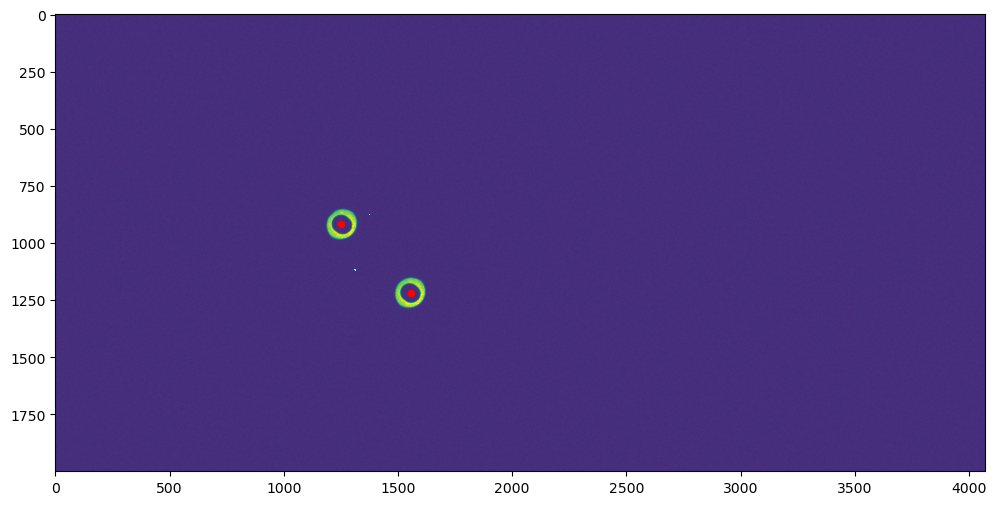

In [25]:
fig = plt.figure(figsize=(12, 7))
plt.imshow(postIsrIntraCwfs.getImage().getArray(), vmax=300)
plt.scatter(cwfsDonutCatIntra.donutCatalog['centroid_x'], cwfsDonutCatIntra.donutCatalog['centroid_y'], c='r', s=20)

## Cut Out Donut Stamps

Changes to the rest of the pipeline tasks are similar. Here when cutting out the donut stamps we will explicitly set the defocal offset to show that it works either way.

In [26]:
from lsst.ts.wep.task.CutOutDonutsCwfsTask import CutOutDonutsCwfsTask, CutOutDonutsCwfsTaskConfig
from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig

In [27]:
cwfsCutOutConfig = CutOutDonutsCwfsTaskConfig()
print(cwfsCutOutConfig)

{'saveMetadata': True, 'saveLogOutput': True, 'donutTemplateSize': 160, 'donutStampSize': 160, 'initialCutoutPadding': 5, 'opticalModel': 'offAxis', 'instObscuration': 0.61, 'instFocalLength': 10.312, 'instApertureDiameter': 8.36, 'instDefocalOffset': None, 'instPixelSize': 1e-05, 'connections': {'exposures': 'postISRCCD', 'donutCatalog': 'donutCatalog', 'camera': 'camera', 'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra'}}


In [28]:
scienceCutOutConfig = CutOutDonutsScienceSensorTaskConfig()
scienceCutOutConfig.initialCutoutPadding = 5
scienceCutOutConfig.instDefocalOffset = 1.5e-3
print(scienceCutOutConfig)

{'saveMetadata': True, 'saveLogOutput': True, 'donutTemplateSize': 160, 'donutStampSize': 160, 'initialCutoutPadding': 5, 'opticalModel': 'offAxis', 'instObscuration': 0.61, 'instFocalLength': 10.312, 'instApertureDiameter': 8.36, 'instDefocalOffset': 0.0015, 'instPixelSize': 1e-05, 'connections': {'exposures': 'postISRCCD', 'donutCatalog': 'donutCatalog', 'camera': 'camera', 'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra'}}


In [29]:
cwfsCutOutTask = CutOutDonutsCwfsTask(config=cwfsCutOutConfig)
cwfsCutOuts = cwfsCutOutTask.run(
    [postIsrExtraCwfs, postIsrIntraCwfs], 
    [cwfsDonutCatExtra.donutCatalog, cwfsDonutCatIntra.donutCatalog], 
    camera
)

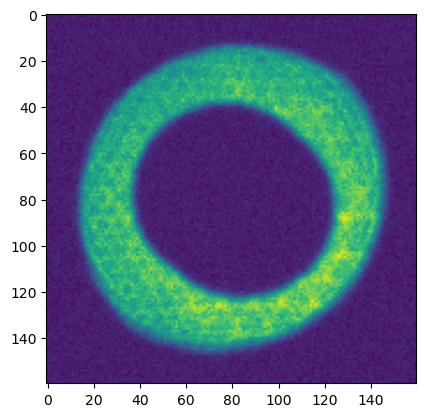

In [30]:
plt.imshow(cwfsCutOuts.donutStampsIntra[0].stamp_im.getImage().getArray())

In [31]:
scienceCutOutTask = CutOutDonutsScienceSensorTask(config=scienceCutOutConfig)
scienceCutOuts = scienceCutOutTask.run(
    [postIsrExtraScience, postIsrIntraScience], 
    [scienceSensorDonutCat.donutCatalog]*2,
    camera
)

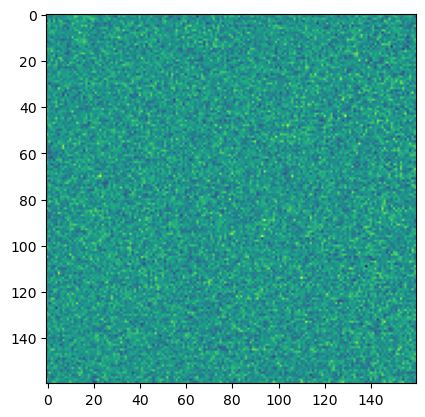

In [32]:
plt.imshow(scienceCutOuts.donutStampsIntra[0].stamp_im.getImage().getArray())

## Calculate Zernikes

Tasks that do not require the exposures such as `CalcZernikes...Task` are unchanged with this update since they don't require the instrument configuration.

## Changes to pipeline yaml files <a id='pipelineFiles'></a>

In the `ts_wep/policy/cwfs/instData/` directory where instrument data was previously hard-coded we have added default parameter files for the existing instruments that can be directly imported into pipeline configuration files that already exist with a small two line change.

Here is the example parameter file for auxTel in the `policy/cwfs/auxTel` directory. It has the settings we want and the task in which we want to apply them.

In [33]:
! cat $ts_wep_dir/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml

description: LATISS Telescope Parameters
instrument: lsst.obs.lsst.Latiss

tasks:
  estimateZernikesLatissTask:
    class: lsst.ts.wep.task.EstimateZernikesLatissTask.EstimateZernikesLatissTask
    config:
      # Obscuration (inner_radius / outer_radius of primary mirror)
      instObscuration: 0.3525
      # Focal length in m
      instFocalLength: 21.6
      # Aperture diameter in m
      instApertureDiameter: 1.2
      # Move the M2 to fake the move of focal plane dz
      # Move the M2 by 0.8 mm = move the focal plane by 32.8 mm  (magnification of 41)
      # Defocal distance offset in mm
      instDefocalOffset: 32.8
      # Camera pixel size in m
      instPixelSize: 10.0e-6


Now we can `import` this into the pipeline configuration file we want to run through the use of the `imports` method available. See this in action in the `testLatissPipeline.yaml` file below. We use `imports` and then specify the location of the configuration file and that's it! Even though we specified other parameters for the same task in this pipeline file it will add in the imported parameters and use them all together.

In [34]:
! cat $ts_wep_dir/tests/testData/pipelineConfigs/testLatissPipeline.yaml

description: ISR basic processing pipeline
instrument: lsst.obs.lsst.Latiss
# Use imported instrument configuration
imports:
  - location: $TS_WEP_DIR/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    config:
      connections.outputExposure: postISRCCD
      doApplyGains: false
      doBias: true
      doBrighterFatter: false
      doCrosstalk: false
      doDark: true
      doDefect: false
      doFlat: true
      doFringe: true
      doInterpolate: true
      doLinearize: false
      doNanMasking: false
      doOverscan: true
      doVariance: false
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
  generateDonutDirectDetectTask:
    class: lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTask
    config:
      donutTemplateSize: 200
      removeBlends: True
      opticalModel: 'onAxis'
  estimateZernikesLatissTask:
    class: lsst.ts.wep.task.EstimateZernikesLatissTask.Esti